# Machine learning for genetic data (Part 1): simulated data


## Introduction

The goal of this practical session is to manipulate high-dimensional, low sample-size data that is typical of many genetic applications. For the sake of illustration, we work first on simulated data, in order to get familiar with the main machine learning techniques. The advantage of simulated data is that we can control the size of the datasets, and the structure of the predictive models.

## Preliminaries
We first import some packages in Python and fix some graphical parameters

In [1]:
# Tell Python we want the figures plotted inline
%pylab inline
prop_cycle = plt.rcParams['axes.prop_cycle']
def_colors = prop_cycle.by_key()['color']
plt.rc('font', **{'size': 18})

Populating the interactive namespace from numpy and matplotlib


## Data simulation
Let us first simulate a dataset to mimic what could be a set of genotypes, and associated phenotype. The genotype of an individual describes its genome. In a given species, all individuals share more than 99.9% of their DNA, but the relatively few varying positions are responsible for the differences between individuals. Here we focus on single-nucleotide differences, called SNP (Single Nucleotide Polymorphism). In humans, for example, there are a few millions of documented SNP (among 3 billions nucleotide in the full genome), i.e., positions in the genome where we have observed at least two possible nucleotides (among A, C, G, T) in all sequenced individuals. The genotype of an individual is the list of nucleotides at all SNP positions; in humans, this is therefore a list of a few millions entries that characterizes the DNA of each individual.

Here, we simulate a species with only 1000 SNPs, to make the following computations easy. We represent a SNP by a binary indicator, which is sufficient when only two nucleotides are possible at each SNP position. We consider a dataset of 150 individuals, to respect the fact that the number of individuals is usually much smaller than the number of SNP in such a study.

To each individual we associate a quantitative phenotype (e.g., the size of the individual), and we assume that a few SNPs explain the phenotype following a linear model.

In addition, we assume that a network of SNP is given, and that the causal SNP form a module of this network; here we simulate a modular network to mimic this hypothesis.

In [2]:
# Number of features (SNP)
num_feats = 1000
# Number of samples
num_obsvs = 150
# Size of modules in the network of features
mod_size = 10
# Number of causal SNP
num_causl = 10

### Simulate features X
We create a matrix of SNP in a very naive way. In particular there is no correlation among SNP nor among individuals, which is rarely the case on real data.

In [3]:
X = np.random.binomial(1, 0.2, size=(num_obsvs, num_feats))
print(X.shape)

(150, 1000)


In [4]:
print(X)

[[0 1 0 ... 0 0 0]
 [0 1 0 ... 0 1 0]
 [0 0 1 ... 0 0 1]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


### Simulate phenotype y
We simulate a phenotype with a sparse linear model. The SNP with nonzero weights in the model form the first module of the network.

In [5]:
# Create random weights
w_causl = np.random.normal(loc=0.2, scale=0.05, size=(num_causl))
print(w_causl)

[0.15564123 0.25357554 0.16216561 0.1356679  0.18044868 0.24093878
 0.21889626 0.17152767 0.15544873 0.24856099]


In [6]:
# Create phenotypes
w = np.zeros((num_feats, ))
w[:num_causl] = w_causl

y = np.matmul(X, w) + np.random.normal(loc=0., scale=0.1, size=(num_obsvs, ))

Text(0,0.5,'frequency')

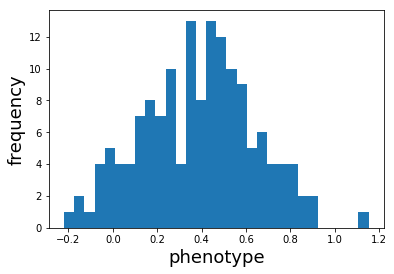

In [7]:
h = plt.hist(y, bins=30)
plt.xlabel("phenotype", fontsize=18)
plt.ylabel("frequency", fontsize=18)

### Simulate network W
We create a modular network

In [8]:
W = np.zeros((num_feats, num_feats))
for i in range(round(num_feats/mod_size)):
    W[i*mod_size:(i+1)*mod_size, i*mod_size:(i+1)*mod_size] = np.ones((mod_size, mod_size))
    if not i == (num_feats/mod_size - 1):
        W[(i+1)*mod_size-1, (i+1)*mod_size] = 1
        W[(i+1)*mod_size, (i+1)*mod_size-1] = 1
        
# remove the diagonal
W = W - np.eye(num_feats)

In [9]:
print(W[1:12,1:12])

[[0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


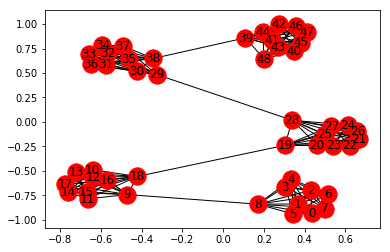

In [10]:
# Visualize the first 5 modules of the network
import networkx as nx
G1=nx.from_numpy_matrix(W[1:50,1:50])
graph_pos=nx.spring_layout(G1,k=0.50,iterations=50)
nx.draw_networkx(G1,graph_pos)

### Shuffle the order of SNP to make it less boring

In [11]:
map_indices_l = list(range(num_feats))
np.random.shuffle(map_indices_l)
map_indices = dict(zip(range(num_feats), map_indices_l))
map_indices_r = dict(zip(map_indices_l, range(num_feats)))
X = X[:, map_indices_l] 
W_new = W[map_indices_l, :]
W_new = W_new[:, map_indices_l]
W = W_new
causl = [map_indices_r[ix] for ix in range(num_causl)]

### Train-test split
We randomly split the observations into a training set (70% of all data) and a test set (30%).

In [12]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y, test_size=0.3, random_state=17)

Check the size of the different matrices!

In [13]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(105, 1000) (45, 1000) (105,) (45,)


# Checking the TRUE model

Let us visualize the weights of the true model

(0, 1000)

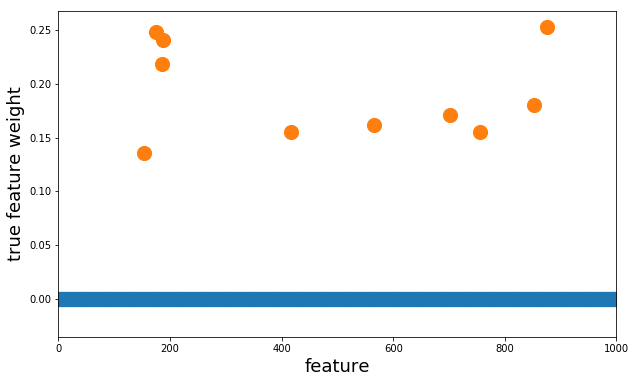

In [14]:
fig = plt.figure(figsize(10, 6))

plt.scatter(range(num_feats), # x = SNP position
            np.zeros(shape=(num_feats, )), # weight = 0 
            s=200) # marker size

# Plot the causal SNPs in red
plt.scatter(causl, w_causl, s=200)

plt.xlabel("feature", fontsize=18)
plt.ylabel("true feature weight", fontsize=18)
plt.xlim([0, num_feats])

Let us check how good the true model predicts the phenotypes on the test set

In [15]:
y_pred = np.dot(X_test[:, causl], w_causl)
from sklearn import metrics
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print("Percentage of variance explained (using all SNPs): %.2f\nRMSE: %2f" % \
    (metrics.explained_variance_score(y_test, y_pred), rmse))

Percentage of variance explained (using all SNPs): 0.88
RMSE: 0.098964


Text(0,0.6,'RMSE = 0.10')

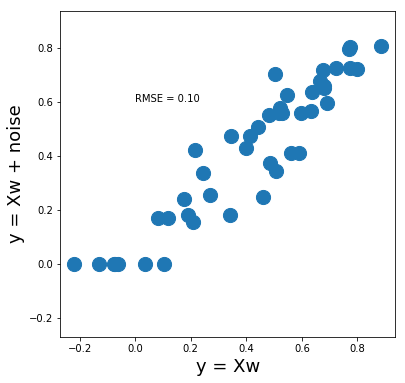

In [16]:
# Scatter plot predicted vs true y
fig = plt.figure(figsize(6, 6))

plt.scatter(y_test, y_pred, s=200)

plt.xlabel("y = Xw", fontsize=18)
plt.ylabel("y = Xw + noise", fontsize=18)
plt.xlim([np.min(y_test)-0.05, np.max(y_test)+0.05])
plt.ylim([np.min(y_test)-0.05, np.max(y_test)+0.05])

plt.text(0, 0.6, 'RMSE = %.2f' % rmse)

## T-test

Let us start by running a statistical test for association of each SNP feature with the phenotype.

In [17]:
import statsmodels.api as sm

In [18]:
pvalues = []
for feat_idx in range(num_feats):
    # only look a the column corresponding at that SNP
    myX = X_train[:, feat_idx]
    # run a linear regression (with bias) between the phenotype and 
    # this SNP
    myX = sm.add_constant(myX)
    est = sm.regression.linear_model.OLS(y_train, myX)
    est2 = est.fit()
    # get the p-value from the model 
    pvalues.append(est2.pvalues[1])
pvalues = np.array(pvalues)

### Manhattan plot

The common way to visualize such results is by using a Manhattan plot: we will plot all SNPs on the x-axis, and on the y-axis we'll have the opposite of the log base 10 of the p-value. The lower the p-value, the higher the corresponding marker. 

We will also add a horizontal line that corresponds to the _threshold for significance_. Because we are testing multiple hypotheses, we need to lower our threshold accordingly. We will use __Bonferroni correction__ and divide the significance threshold (say, alpha=0.05) by the number of tests, that is, the number of SNPs p.

(0, 1000)

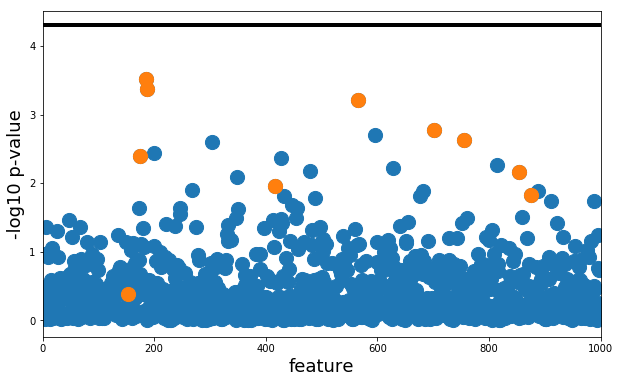

In [19]:
fig = plt.figure(figsize(10, 6))

plt.scatter(range(num_feats), # x = SNP position
            -np.log10(pvalues), # y = -log10 p-value 
            s=200) 

# Plot the causal SNPs in red
plt.scatter(causl, 
            -np.log10(pvalues[causl]),
            color=def_colors[1], s=200)

# significance threshold according to Bonferroni correction
t = -np.log10(0.05/num_feats)
plt.plot([0, num_feats], [t, t], lw=4, c='k')

plt.xlabel("feature", fontsize=18)
plt.ylabel("-log10 p-value", fontsize=18)
plt.xlim([0, num_feats])

Only a few causal features are identified as significant. Even increasing the significance level (or using a less stringent correction for multiple hypothesis testing) would not rescue the 9 other causal features.

## Linear regression
As a first predictive model, let us try the classical ordinary least squares (OLS) method. This is quite bold in a setting where we have more features than observations, but hey, we have to start somewhere!

OLS, like many other methods below, is implemented in Scikit Learn and follows a standard syntax to fit a model on training data, and make predictions on test data.

In [20]:
# Import the linear_model module from Scikit Learn
from sklearn import linear_model

In [21]:
# Define a variable 'model' as an OLS model, ready to be fit
model_OLS = linear_model.LinearRegression(fit_intercept=True)

In [22]:
# Fit the model on training data
model_OLS.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Congratulations! You have fit your first linear model. Let us look at how it looks, ie, what are the weights of the fitted model.

(0, 1000)

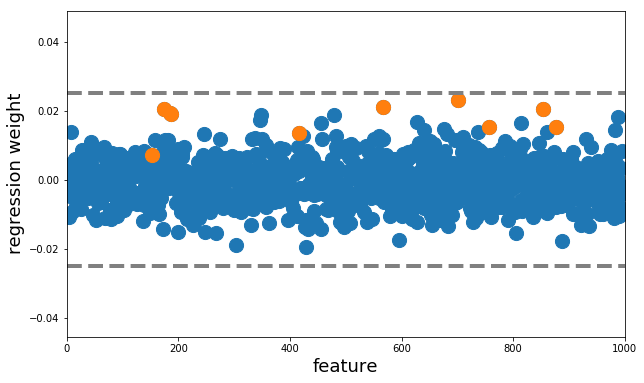

In [23]:
fig = plt.figure(figsize(10, 6))

plt.scatter(range(num_feats), # x = SNP position
            model_OLS.coef_,  # y = regression weights
            s=200)

plt.scatter(causl, model_OLS.coef_[causl],
            color=def_colors[1], s=200) # plot the weights of the causal SNP in red

plt.plot([0, num_feats], [0.025, 0.025], lw=4, c='grey', ls='--') 
plt.plot([0, num_feats], [-0.025, -0.025], lw=4, c='grey', ls='--')


plt.xlabel("feature", fontsize=18)
plt.ylabel("regression weight", fontsize=18)
plt.xlim([0, num_feats])

The features that have the largest weight (in magnitude) are not necessarily the causal ones. Some causal features have a very low weight.

The dashed lines at +/- 0.025 have been chosen arbitrarily.

### Predictive power on the validation set
Another way to check if the fitted model is good or not, is to check how well it predits on data that were not used during training. So let's see how well OLS predicts on our test set

In [24]:
# Predict on the validation set
y_pred_OLS = model_OLS.predict(X_test)

In [25]:
# Assess performance
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_OLS))
print("Percentage of variance explained (using all SNPs): %.2f\nRMSE: %2f" % \
    (metrics.explained_variance_score(y_test, y_pred_OLS), rmse))

Percentage of variance explained (using all SNPs): 0.13
RMSE: 0.262532


Text(0,0.6,'RMSE = 0.26')

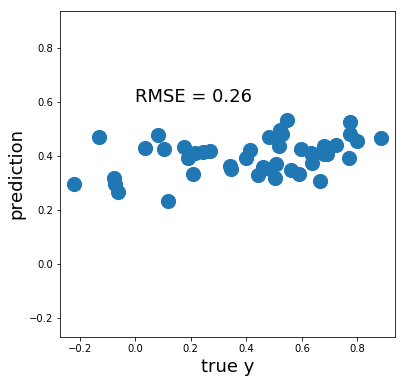

In [26]:
# Scatter plot predicted vs true y
fig = plt.figure(figsize(6, 6))

plt.scatter(y_test, y_pred_OLS, s=200)

plt.xlabel("true y", fontsize=18)
plt.ylabel("prediction", fontsize=18)
plt.xlim([np.min(y_test)-0.05, np.max(y_test)+0.05])
plt.ylim([np.min(y_test)-0.05, np.max(y_test)+0.05])

plt.text(0, 0.6, 'RMSE = %.2f' % rmse, fontsize=18)

## Lasso
Lasso regression is a sparse regression techniques, which minimizes the mean squared error penalized by the L1 norm of the predictor. The non-differentiability of the L1 norm leads to sparse solutions, i.e., predictors where only a finite subset of SNP are used in the model. The number of SNPs in the model can be controlled by the regularization parameter which adds more or less penalty.

Lasso regression is implemented in Scikit Learn. The regularization parameter is called 'alpha'. Larger alpha's lead to sparser models, i.e., less SNPs selected. Let us for example instanciate a Lasso model with, arbitraritly, a regularization parameter equal to 0.01

In [54]:
model_l1 = linear_model.Lasso(fit_intercept=True, alpha=0.02)

We train the model on the training set with the standard 'fit' method:

In [55]:
model_l1.fit(X_train, y_train)

Lasso(alpha=0.02, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

Let us check how the trained model looks like. The coefficients are in the 'coef_' field of the trained model.

(0, 1000)

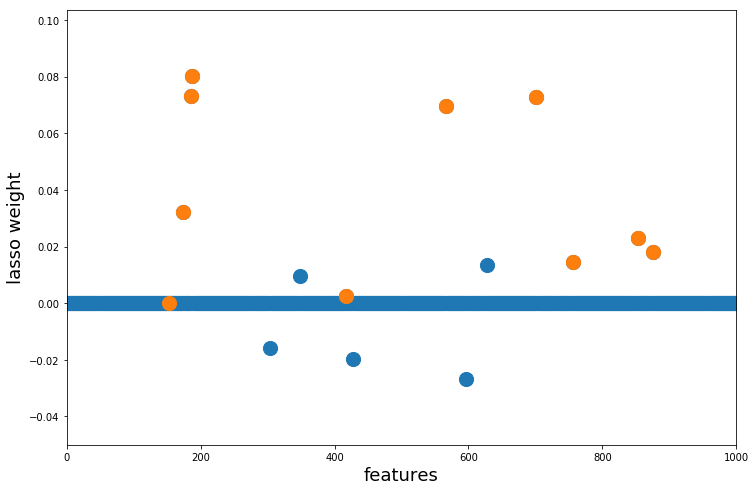

In [57]:
fig = plt.figure(figsize(12, 8))

plt.scatter(range(num_feats), # x = SNP position
            model_l1.coef_, # y = regression weight
            s=200)

plt.scatter(causl, model_l1.coef_[causl],
            color=def_colors[1], s=200)

plt.xlabel("features", fontsize=18)
plt.ylabel("lasso weight", fontsize=18)
plt.xlim([0, num_feats])

Not bad! Many causal SNP are selected, and only a few non-causal SNP are also selected. However, some causal SNP are also not selected. Maybe we regularized too much?

A solution to choosed a "good" regularization parameter is to test a grid of candidate parameters by cross-validation, and pick the one that gives the best cross-validated performance. Luckily this whole cross-validated optimization is implemented in Scikit Learn.

In [62]:
# A grid of parameters
alphas = np.logspace(-4., 0., num=20)
# A model we want to optimize
lasso = linear_model.Lasso(fit_intercept=True)
# The cross-validation object
model_l1_cv = model_selection.GridSearchCV(lasso, 
                                        param_grid={'alpha': alphas}, 
                                        scoring='explained_variance')

Now we can run the cross-validated optimization on our training set.

In [63]:
model_l1_cv.fit(X_train, y_train)

/Users/jp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You 

GridSearchCV(cv=None, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([1.00000e-04, 1.62378e-04, 2.63665e-04, 4.28133e-04, 6.95193e-04,
       1.12884e-03, 1.83298e-03, 2.97635e-03, 4.83293e-03, 7.84760e-03,
       1.27427e-02, 2.06914e-02, 3.35982e-02, 5.45559e-02, 8.85867e-02,
       1.43845e-01, 2.33572e-01, 3.79269e-01, 6.15848e-01, 1.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='explained_variance', verbose=0)

What is the best alpha estimated by cross-validation, and how many SNP are selected for the best model?

Text(0,0.5,'Mean test explained variance')

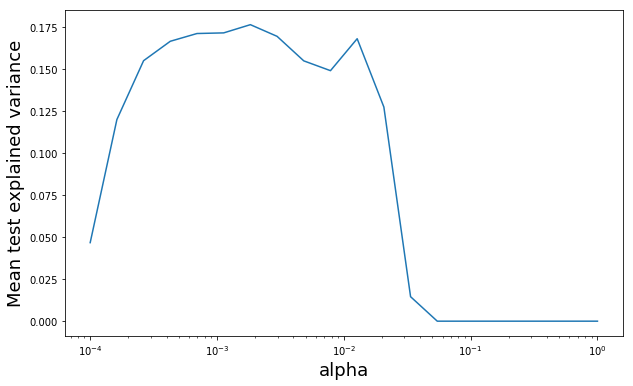

In [64]:
# Plot CV performance
scores = model_l1_cv.cv_results_['mean_test_score']
fig = plt.figure(figsize(10, 6))
plt.semilogx(alphas, scores)
plt.xlabel("alpha", fontsize=18)
plt.ylabel("Mean test explained variance", fontsize=18)

In [65]:
print("Best alpha: %.4f" % \
      model_l1.best_estimator_.alpha)
print("%d SNPs selected." % \
    np.nonzero(model_l1.best_estimator_.coef_)[0].shape)

Best alpha: 0.0016
84 SNPs selected.


The "best" model, with the alpha parameters that optimizes the cross-validated performance, is stored in the 'best_estimator_' field. Let's look at its weights.

(0, 1000)

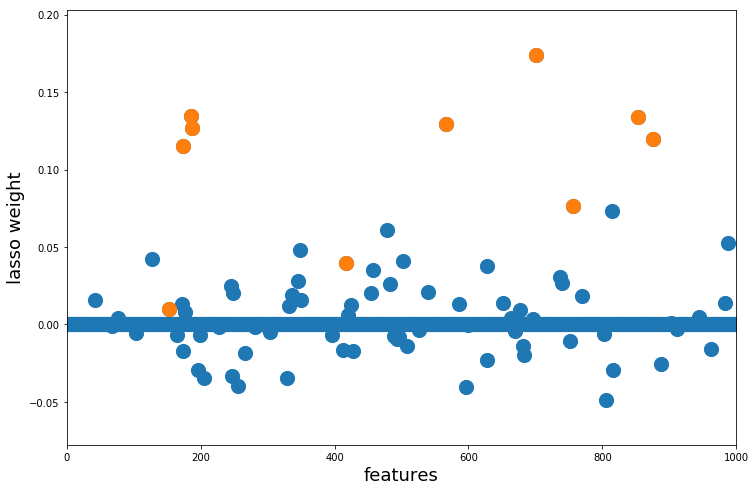

In [66]:
fig = plt.figure(figsize(12, 8))

plt.scatter(range(num_feats), # x = SNP position
            model_l1.best_estimator_.coef_, # y = regression weight
            s=200)

plt.scatter(causl, model_l1.best_estimator_.coef_[causl],
            color=def_colors[1], s=200)

plt.xlabel("features", fontsize=18)
plt.ylabel("lasso weight", fontsize=18)
plt.xlim([0, num_feats])

The solution is sparse, but many non-causal features have non-zero weights. It is a general property of the LASSO that when performance is optimized, it is better to include too many features than not enough.

Let us now look at how good the model predicts the phenotype on the test set.

In [67]:
# Predict on the validation set
y_pred = model_l1_cv.predict(X_test)

In [68]:
# Assess performance
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print("Percentage of variance explained (using all SNPs): %.2f\nRMSE: %2f" % \
    (metrics.explained_variance_score(y_test, y_pred), rmse))

Percentage of variance explained (using all SNPs): 0.58
RMSE: 0.183207


Text(0,0.6,'RMSE = 0.18')

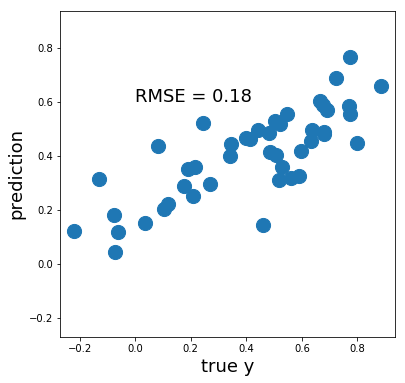

In [69]:
# Scatter plot predicted vs true y
fig = plt.figure(figsize(6, 6))

plt.scatter(y_test, y_pred, s=200)

plt.xlabel("true y", fontsize=18)
plt.ylabel("prediction", fontsize=18)
plt.xlim([np.min(y_test)-0.05, np.max(y_test)+0.05])
plt.ylim([np.min(y_test)-0.05, np.max(y_test)+0.05])

plt.text(0, 0.6, 'RMSE = %.2f' % rmse, fontsize=18)

## Elastic net
Elastic net is a generalization of Lasso. It also creates sparse models, but can be better than lasso in particular in the presence of correlated features.

Elastic net regularizes the mean squared error by a sum of two penalties: a L1 penalty (like the lasso), and a L2 penalty. It therefore has two regularization parameters, which are encoded in Scikit Learn as 'alpha' (the total amount of regularization), and 'l1_ratio' (the fraction of L1 penalty compared to L2). Setting 'l1_ratio' to 1 boils down to standard Lasso regression.

As for Lasso, we can automatically choose the parameters by cross-validation:

In [70]:
# Parameters grid
alphas = np.logspace(-3., 1., num=15)
ratios = np.linspace(0.5, 1., num=3)

In [72]:
# Define the elastic net model
enet = linear_model.ElasticNet(fit_intercept=True)
# Define the cross-validation procedure
model_l1l2 = model_selection.GridSearchCV(enet, 
                                        param_grid={'alpha': alphas, 
                                                    'l1_ratio': ratios}, 
                                        scoring='explained_variance')
# Train the elastic net model with parameter optimization by cross-validation
model_l1l2.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([1.00000e-03, 1.93070e-03, 3.72759e-03, 7.19686e-03, 1.38950e-02,
       2.68270e-02, 5.17947e-02, 1.00000e-01, 1.93070e-01, 3.72759e-01,
       7.19686e-01, 1.38950e+00, 2.68270e+00, 5.17947e+00, 1.00000e+01]), 'l1_ratio': array([0.5 , 0.75, 1.  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='explained_variance', verbose=0)

As usual, let's look at the weights of the models, and how well it predicts phenotypes on the test set

(0, 1000)

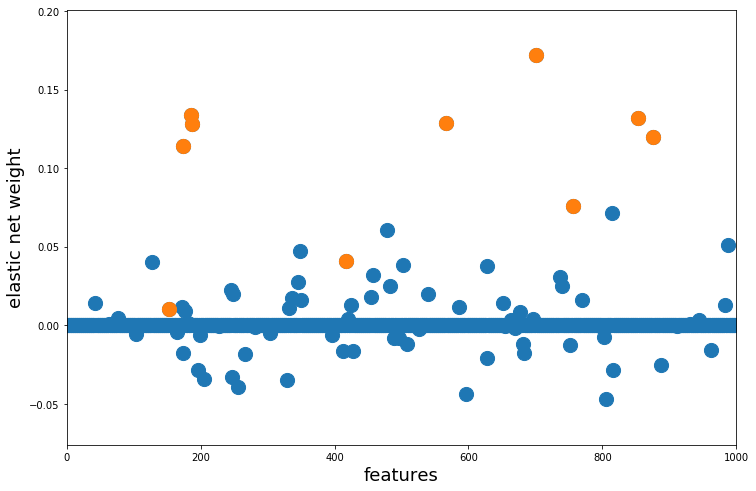

In [73]:
fig = plt.figure(figsize(12, 8))

plt.scatter(range(num_feats), # x = SNP position
            model_l1l2.best_estimator_.coef_, # y = regression weight
            s=200)

plt.scatter(causl, model_l1l2.best_estimator_.coef_[causl],
            color=def_colors[1], s=200)

plt.xlabel("features", fontsize=18)
plt.ylabel("elastic net weight", fontsize=18)
plt.xlim([0, num_feats])

Percentage of variance explained (using all SNPs): 0.58
RMSE: 0.182976


Text(0,0.6,'RMSE = 0.18')

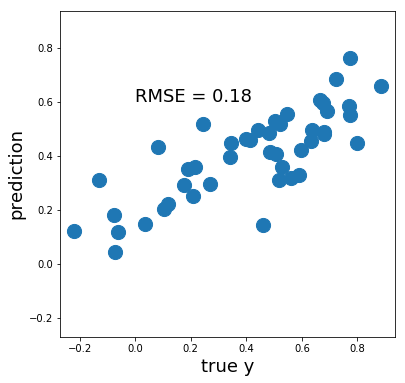

In [74]:
# Predict on the validation set
y_pred = model_l1l2.predict(X_test)

# Assess performance
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print("Percentage of variance explained (using all SNPs): %.2f\nRMSE: %2f" % \
    (metrics.explained_variance_score(y_test, y_pred), rmse))

# Scatter plot predicted vs true y
fig = plt.figure(figsize(6, 6))

plt.scatter(y_test, y_pred, s=200)

plt.xlabel("true y", fontsize=18)
plt.ylabel("prediction", fontsize=18)
plt.xlim([np.min(y_test)-0.05, np.max(y_test)+0.05])
plt.ylim([np.min(y_test)-0.05, np.max(y_test)+0.05])

plt.text(0, 0.6, 'RMSE = %.2f' % rmse, fontsize=18)

## Stability selection

Stability selection is a technique to improve the feature selection process of a given procedure, here the Lasso. Instead of running the Lasso only once to select features, stability selection runs the Lasso many times, on randomly perturbed training sets (by subsampling examples and reweighting variables). The features are then scored by how frequently they are selected by the lasso, and the most highly scored features are kept.

Although deprecated, Scikit Learn as a convenient implementation of stability selection.

In [76]:
# A stability selection object (we just need to fix a value for alpha)
randlasso = linear_model.RandomizedLasso(
    alpha=model_l1_cv.best_params_['alpha'])
# Train the model
randlasso.fit(X_train, y_train)


/Users/jp/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


RandomizedLasso(alpha=0.0018329807108324356, eps=2.220446049250313e-16,
        fit_intercept=True, max_iter=500, memory=None, n_jobs=1,
        n_resampling=200, normalize=True, pre_dispatch='3*n_jobs',
        precompute='auto', random_state=None, sample_fraction=0.75,
        scaling=0.5, selection_threshold=0.25, verbose=False)

Let's visualize the scoring of the features by stability selection. Note that the vertical axis is not the weights of a model, but the selection frequency of each feature during stability selection.

(0, 1000)

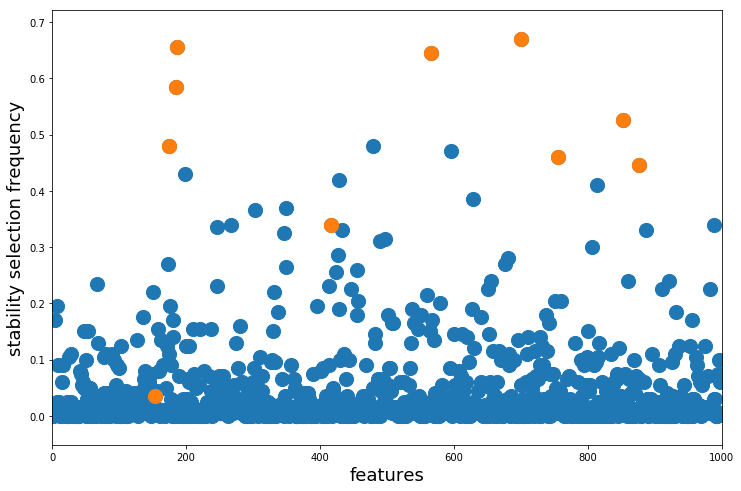

In [77]:
fig = plt.figure(figsize(12, 8))

plt.scatter(range(num_feats), # x = SNP position
            randlasso.scores_, # y = regression weight
            s=200)

plt.scatter(causl, randlasso.scores_[causl],
            color=def_colors[1], s=200)

plt.xlabel("features", fontsize=18)
plt.ylabel("stability selection frequency", fontsize=18)
plt.xlim([0, num_feats])

# Network-constrained Lasso

Network-constrained Lasso (ncLasso) is a variant of elastic net, and requires the knowledge of a graph to describe relationships between features. The main assumptions behind ncLasso are not only that the model is sparse (like Lasso or elastic net), but also that the features with non-zero weights of the model tend to be connected in the network, and to have similar weights when they are connected.

Mathematically, ncLasso follows elastic net by minimizing a sum of squared error criterion penalized by two regularization, a L1 penalty (to enforce sparsity), and a graph-modified L2 penalty. The graph-modified L2 penalty enforces smoothness of the coefficients on the graph.

This method, developed by [Li and Li (2008)](https://academic.oup.com/bioinformatics/article/24/9/1175/206444) is not implemented in scikit-learn, so we'll need to create our own estimator.

It turns out that it is possible to transform the network-constrained Lasso problem into a Lasso problem: follow [the original paper](https://academic.oup.com/bioinformatics/article/24/9/1175/206444) (pdf also available [here](http://www.stat.purdue.edu/~doerge/BIOINFORM.D/FALL10/Li_and_Li_2008_Bioinformatics.pdf) and the note in section C of [the supplementary material of Sugiyama et al. (2014)](http://cazencott.info/dotclear/public/publications/sugiyama2014_supp.pdf) to replace the eigen-decomposition of the graph Laplacian with the graph incidence matrix.

Follow the [documentation](http://scikit-learn.org/stable/developers/contributing.html#rolling-your-own-estimator) or this [blog post](http://danielhnyk.cz/creating-your-own-estimator-scikit-learn/) to create a scikit-learn estimator.

Be careful: the computations might require a lot of RAM.

In [41]:
from sklearn import base, linear_model
from scipy import sparse

In [42]:
class ncLassoOriginal(base.BaseEstimator, base.RegressorMixin):
    def __init__(self, LapSqrt=None, lambda1=1.0, lambda2=1.0):
        self.LapSqrt = LapSqrt # sparse matrix
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        
    def fit(self, X, y):       
        alpha = self.lambda1/(np.sqrt(self.lambda2+1.))
        self.lasso = linear_model.Lasso(fit_intercept=True, alpha=alpha)
        
        y_new = np.hstack((y, np.zeros((self.LapSqrt.shape[0], ))))
        X_new = 1/(np.sqrt(self.lambda2+1)) * sparse.vstack((X, np.sqrt(self.lambda2)*\
                                                    self.LapSqrt))
        
        self.lasso.fit(X_new, y_new)
        self.coef_ = self.lasso.coef_[:X.shape[1]]/(np.sqrt(self.lambda2+1))
        return self
        
        
    def predict(self, X, y=None):
        return self.lasso.predict(X)
    
    
    def score(self, X, y=None):
        return self.lasso.score(X, y)                                        

In [78]:
class ncLasso(base.BaseEstimator, base.RegressorMixin):
    def __init__(self, LapSqrt=None, lambda1=1.0, lambda2=1.0):
        self.LapSqrt = LapSqrt # sparse matrix
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        
    def fit(self, X, y):       
        self.lasso = linear_model.Lasso(fit_intercept=True, alpha=self.lambda1)
        
        y_new = np.hstack((y, np.zeros((self.LapSqrt.shape[0], ))))
        X_new = sparse.vstack((X, np.sqrt(self.lambda2)*\
                                                    self.LapSqrt))
        
        self.lasso.fit(X_new, y_new)
        self.coef_ = self.lasso.coef_ * (1+self.lambda2)
        return self
        
        
    def predict(self, X, y=None):
        return self.lasso.predict(X) * (1+self.lambda2)
    
    
    def score(self, X, y=None):
        return self.lasso.score(X, y)                                        

Let us compute a square root of the Laplacian by eigenvector decomposition

In [79]:
degree = np.sum(W, axis=0)
L = np.diag(degree) - W

# spectral decomposition
evals, evecs = np.linalg.eigh(L)

# correct for numerical errors: 
# eigenvalues of 0 might be computed as small negative numbers
evals = np.maximum(0, evals)

# Square root
S = np.dot(np.diag(np.sqrt(evals)), evecs.T)

In [45]:
# Check that we have a correct square root
print(np.max(np.abs(np.matmul(S.T, S) - L)))

2.4868995751603507e-14


In [112]:
# Fit a ncLasso
model_ncLasso = ncLasso(LapSqrt=S, lambda1=0.002, lambda2=2.)
model_ncLasso.fit(X_train, y_train)

ncLasso(LapSqrt=array([[-8.53568e-10, -8.53568e-10, ..., -8.53568e-10, -8.53568e-10],
       [ 1.55203e-04,  2.63394e-04, ...,  2.91247e-04,  4.03116e-04],
       ...,
       [ 1.28248e-03,  2.83725e-04, ..., -5.69697e-05, -1.77002e-03],
       [-3.47051e-04, -5.88976e-04, ..., -6.51260e-04, -9.01411e-04]]),
    lambda1=0.002, lambda2=2.0)

(0, 1000)

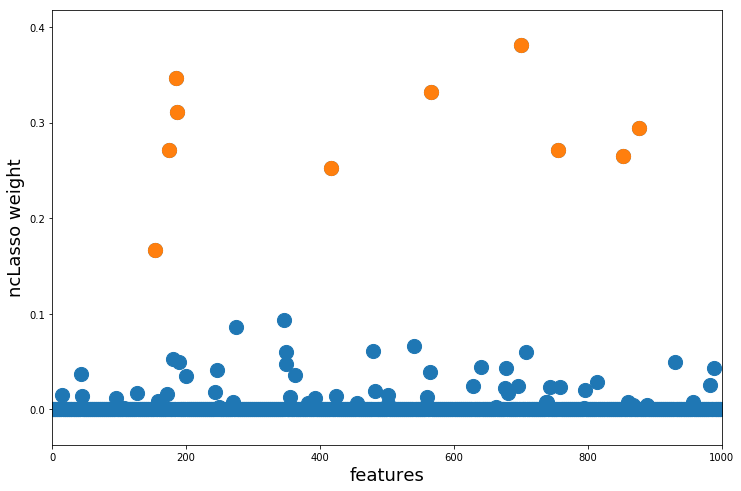

In [113]:
fig = plt.figure(figsize(12, 8))

plt.scatter(range(num_feats), # x = SNP position
            model_ncLasso.coef_, # y = regression weight
            s=200)

plt.scatter(causl, model_ncLasso.coef_[causl],
            color=def_colors[1], s=200)

plt.xlabel("features", fontsize=18)
plt.ylabel("ncLasso weight", fontsize=18)
plt.xlim([0, num_feats])

Percentage of variance explained (using all SNPs): 0.41
RMSE: 0.578045


Text(0,0.6,'RMSE = 0.58')

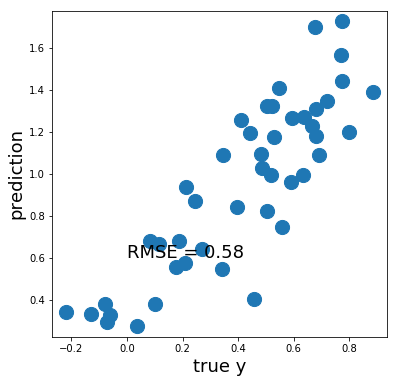

In [114]:
# Predict on the validation set
y_pred = model_ncLasso.predict(X_test)

# Assess performance
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print("Percentage of variance explained (using all SNPs): %.2f\nRMSE: %2f" % \
    (metrics.explained_variance_score(y_test, y_pred), rmse))

fig = plt.figure(figsize(6, 6))

plt.scatter(y_test, y_pred, s=200)

plt.xlabel("true y", fontsize=18)
plt.ylabel("prediction", fontsize=18)
plt.xlim([np.min(y_test)-0.05, np.max(y_test)+0.05])
plt.ylim([np.min(y_pred)-0.05, np.max(y_pred)+0.05])

plt.text(0, 0.6, 'RMSE = %.2f' % rmse, fontsize=18)